# Data Preprocessing

In [31]:
# import required package
import requests
import pandas as pd
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [43]:
# Load data if starting from here
features_df = pd.read_csv('../1. Data Preparation/github_repo_features.csv')

# Initialize dictionary to store encoders
encoders = {}

# Convert dates to datetime with UTC timezone
for col in ['created_at', 'updated_at', 'pushed_at']:
    features_df[col] = pd.to_datetime(features_df[col], utc=True).dt.tz_localize(None)
    features_df[f'{col}_days'] = (features_df[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d')

    
    
## About Unix Epoch/Time (1970-01-01)
# Unix time is a date and time representation widely used in computing.
# Alternative approach that handles timezones more explicitly:
# for col in ['created_at', 'updated_at', 'pushed_at']:
#     # Parse with UTC timezone
#     features_df[col] = pd.to_datetime(features_df[col], utc=True)
#     # Create a timezone-aware epoch timestamp
#     epoch = pd.Timestamp("1970-01-01", tz='UTC')
#     features_df[f'{col}_days'] = (features_df[col] - epoch) // pd.Timedelta('1d')

# Encode categorical variables (IMPROVED VERSION)
categorical_cols = ['language', 'license']
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    features_df[col] = encoders[col].fit_transform(features_df[col].astype(str))
    
    # Print encoding mapping for verification
    print(f"\n{col.capitalize()} Encoding Mapping:")
    for i, cat in enumerate(encoders[col].classes_):
        print(f"{cat}: {i}")

# Drop unnecessary columns
drop_cols = ['name', 'full_name', 'created_at', 'updated_at', 'pushed_at']
features_df = features_df.drop(columns=drop_cols)

# Handle missing values
features_df = features_df.fillna(0)

# Define target and features
X = features_df.drop(columns=['stars'])
y = features_df['stars']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save all preprocessing objects
joblib.dump(encoders, 'github_encoders.pkl')
joblib.dump(scaler, 'github_scaler.pkl')


Language Encoding Mapping:
Assembly: 0
Astro: 1
Batchfile: 2
Blade: 3
C: 4
C#: 5
C++: 6
CSS: 7
Clojure: 8
Cuda: 9
Dart: 10
Dockerfile: 11
Elixir: 12
Go: 13
HTML: 14
Haskell: 15
Java: 16
JavaScript: 17
Jinja: 18
Julia: 19
Jupyter Notebook: 20
Kotlin: 21
LLVM: 22
Lua: 23
MDX: 24
Makefile: 25
Markdown: 26
Nunjucks: 27
Objective-C: 28
PHP: 29
PowerShell: 30
Python: 31
Roff: 32
Ruby: 33
Rust: 34
SCSS: 35
Scala: 36
Shell: 37
Svelte: 38
Swift: 39
TeX: 40
TypeScript: 41
V: 42
Vim Script: 43
Vue: 44
Zig: 45
nan: 46

License Encoding Mapping:
agpl-3.0: 0
apache-2.0: 1
bsd-2-clause: 2
bsd-3-clause: 3
cc-by-4.0: 4
cc-by-sa-4.0: 5
cc0-1.0: 6
gpl-2.0: 7
gpl-3.0: 8
isc: 9
lgpl-3.0: 10
mit: 11
mpl-2.0: 12
nan: 13
ofl-1.1: 14
other: 15
unlicense: 16
vim: 17
wtfpl: 18
zlib: 19


['github_scaler.pkl']

In [44]:
import pandas as pd

# Create a DataFrame from the scaled training data
# (We need to inverse transform to see original values)
train_df = pd.DataFrame(scaler.inverse_transform(X_train_scaled), 
                       columns=X_train.columns)

# Add back the target variable
train_df['stars'] = y_train.reset_index(drop=True)

# Print the first 5 samples with selected columns
# print("First 5 training samples:")
# print(train_df.head().to_string())

# Print a nicely formatted version
print("\nFormatted training samples:")
for i in range(5):
    print(f"\nSample {i+1}:")
    sample = train_df.iloc[i]
    print(f"Stars: {sample['stars']}")
    print("Features:")
    for feature, value in sample.drop('stars').items():
        print(f"  {feature}: {value:.2f}" if isinstance(value, (float, int)) else f"  {feature}: {value}")


Formatted training samples:

Sample 1:
Stars: 155830.0
Features:
  forks: 14652.00
  watchers: 155830.00
  open_issues: 248.00
  size: 2772.00
  has_wiki: 0.00
  has_projects: 1.00
  has_downloads: 1.00
  is_fork: 0.00
  archived: 0.00
  language: 46.00
  license: 13.00
  subscribers_count: 30.00
  contributors_count: 30.00
  commits_count: 30.00
  readme_size: 40906.00
  created_at_days: 16575.00
  updated_at_days: 20212.00
  pushed_at_days: 19899.00

Sample 2:
Stars: 36871.0
Features:
  forks: 4028.00
  watchers: 36871.00
  open_issues: 4355.00
  size: 787749.00
  has_wiki: 1.00
  has_projects: 1.00
  has_downloads: 1.00
  is_fork: 0.00
  archived: 0.00
  language: 41.00
  license: 1.00
  subscribers_count: 30.00
  contributors_count: 30.00
  commits_count: 30.00
  readme_size: 54355.00
  created_at_days: 18443.00
  updated_at_days: 20212.00
  pushed_at_days: 20210.00

Sample 3:
Stars: 31720.0
Features:
  forks: 11908.00
  watchers: 31720.00
  open_issues: 27.00
  size: 2036.00
  ha

# Training with Multiple Models

In [45]:
# importing rquired packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                             AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [46]:
# Initialize models with variations
models = {
    # Linear Models
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0),
    'Ridge (α=0.5)': Ridge(alpha=0.5),
    'Lasso (α=0.1)': Lasso(alpha=0.1),
    'ElasticNet (α=0.1)': ElasticNet(alpha=0.1, l1_ratio=0.5),
    
    # Tree-based Models
    'Decision Tree (max_depth=5)': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Decision Tree (max_depth=10)': DecisionTreeRegressor(max_depth=10, random_state=42),
    
    # Ensemble Methods
    'Random Forest (n=100)': RandomForestRegressor(n_estimators=100, random_state=42),
    'Random Forest (n=200)': RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting (n=100)': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting (n=200)': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42),
    'Bagging Regressor': BaggingRegressor(random_state=42),
    
    # SVM
    'SVR (linear)': SVR(kernel='linear'),
    'SVR (rbf)': SVR(kernel='rbf'),
    'SVR (poly)': SVR(kernel='poly'),
    
    # Neighbors
    'KNN (k=3)': KNeighborsRegressor(n_neighbors=3),
    'KNN (k=5)': KNeighborsRegressor(n_neighbors=5),
    'KNN (k=10)': KNeighborsRegressor(n_neighbors=10),
    
    # Neural Networks
    'MLP (1 layer)': MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42),
    'MLP (2 layers)': MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42),
    
    # Gaussian Process
    'Gaussian Process': GaussianProcessRegressor(kernel=ConstantKernel(1.0) * RBF(length_scale=1.0), random_state=42),
    
    # Advanced Gradient Boosting
    'XGBoost': XGBRegressor(random_state=42)
}


In [47]:

# Train and evaluate models
results = []
best_model = None
best_r2 = -np.inf

for name, model in models.items():
    try:
        # Train
        model.fit(X_train_scaled, y_train)
        print("Training: "+name+"\n")
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        model_params = str(model.get_params())
        results.append({
            'Model': name,
            'Parameters': model_params,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
        
        # Track best model
        if r2 > best_r2:
            best_r2 = r2
            best_model = {
                'Model': name,
                'Parameters': model_params,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            }
            
        print(f"{name: <30} | R2: {r2:.4f} | RMSE: {rmse:.2f}")
        
    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        continue

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2', ascending=False)

# Display all results
print("\n=== All Model Results ===")
print(results_df.to_string())

# Display best model
print("\n=== Best Model ===")
print(f"Model: {best_model['Model']}")
print(f"R2 Score: {best_model['R2']:.4f}")
print(f"RMSE: {best_model['RMSE']:.2f}")
print(f"Parameters: {best_model['Parameters']}")


Training: Linear Regression

Linear Regression              | R2: 1.0000 | RMSE: 0.00
Training: Ridge (α=1.0)

Ridge (α=1.0)                  | R2: 1.0000 | RMSE: 46.02
Training: Ridge (α=0.5)

Ridge (α=0.5)                  | R2: 1.0000 | RMSE: 23.05
Training: Lasso (α=0.1)

Lasso (α=0.1)                  | R2: 1.0000 | RMSE: 0.98
Training: ElasticNet (α=0.1)

ElasticNet (α=0.1)             | R2: 0.9967 | RMSE: 1623.89
Training: Decision Tree (max_depth=5)

Decision Tree (max_depth=5)    | R2: 0.9928 | RMSE: 2411.50
Training: Decision Tree (max_depth=10)

Decision Tree (max_depth=10)   | R2: 0.9948 | RMSE: 2046.01
Training: Random Forest (n=100)

Random Forest (n=100)          | R2: 0.9982 | RMSE: 1189.97
Training: Random Forest (n=200)

Random Forest (n=200)          | R2: 0.9987 | RMSE: 1018.96
Training: Gradient Boosting (n=100)

Gradient Boosting (n=100)      | R2: 0.9995 | RMSE: 652.89
Training: Gradient Boosting (n=200)

Gradient Boosting (n=200)      | R2: 0.9995 | RMSE: 635.56

c:\users\admin\music\python\codes\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\admin\music\python\codes\venv\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\admin\music\python\codes\venv\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR (linear)                   | R2: -0.0802 | RMSE: 29508.93
Training: SVR (rbf)

SVR (rbf)                      | R2: -0.1146 | RMSE: 29975.03
Training: SVR (poly)

SVR (poly)                     | R2: -0.1147 | RMSE: 29976.20
Training: KNN (k=3)

KNN (k=3)                      | R2: 0.7945 | RMSE: 12871.09
Training: KNN (k=5)

KNN (k=5)                      | R2: 0.7592 | RMSE: 13932.17
Training: KNN (k=10)

KNN (k=10)                     | R2: 0.6740 | RMSE: 16211.51


c:\users\admin\music\python\codes\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training: MLP (1 layer)

MLP (1 layer)                  | R2: -2.4411 | RMSE: 52668.03


c:\users\admin\music\python\codes\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training: MLP (2 layers)

MLP (2 layers)                 | R2: 0.8758 | RMSE: 10007.07
Training: Gaussian Process

Gaussian Process               | R2: -0.1988 | RMSE: 31086.64
Training: XGBoost

XGBoost                        | R2: 0.9985 | RMSE: 1099.79

=== All Model Results ===
                           Model                                         Parameters           MSE          RMSE           MAE        R2
0              Linear Regression  {'copy_X': True, 'fit_intercept': True, 'n_job...  1.014454e-21  3.185050e-11  2.168235e-11  1.000000
3                  Lasso (α=0.1)  {'alpha': 0.1, 'copy_X': True, 'fit_intercept'...  9.575239e-01  9.785315e-01  5.696862e-01  1.000000
2                  Ridge (α=0.5)  {'alpha': 0.5, 'copy_X': True, 'fit_intercept'...  5.313564e+02  2.305117e+01  1.580692e+01  0.999999
1                  Ridge (α=1.0)  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...  2.117995e+03  4.602168e+01  3.156217e+01  0.999997
12                   Extra Trees  {'b

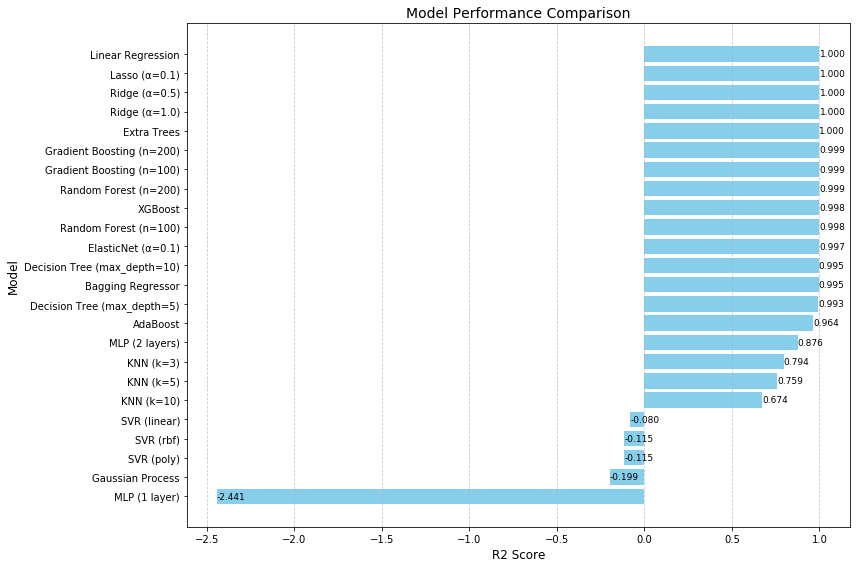

In [37]:
def visualize_results(results_df):
    plt.figure(figsize=(12, 8))
    
    # Sort by R2 score and plot
    results_df = results_df.sort_values(by='R2')
    bars = plt.barh(results_df['Model'], results_df['R2'], color='skyblue')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', 
                va='center', ha='left', fontsize=9)
    
    # Customize plot
    plt.xlabel('R2 Score', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.title('Model Performance Comparison', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save and show
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the visualization function
visualize_results(results_df)

# Save Your Model

In [48]:
import joblib
from sklearn.metrics import r2_score, mean_squared_error


# Get the best model
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = models[best_model_name]

# Save all components
model_filename = 'best_github_stars_predictor.pkl'
joblib.dump(best_model, model_filename)


print(f"Saved components:")
print(f"- Best model ({best_model_name}) to {model_filename}")

Saved components:
- Best model (Linear Regression) to best_github_stars_predictor.pkl


In [49]:
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. Load and preprocess data (with encoder saving)
features_df = pd.read_csv('../1. Data Preparation/github_repo_features.csv')

# Initialize encoders dictionary
encoders = {}

# Date processing
for col in ['created_at', 'updated_at', 'pushed_at']:
    features_df[col] = pd.to_datetime(features_df[col], utc=True).dt.tz_localize(None)
    features_df[f'{col}_days'] = (features_df[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1d')

# Categorical encoding
categorical_cols = ['language', 'license']
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    features_df[col] = encoders[col].fit_transform(features_df[col].astype(str))

# Final preprocessing
features_df = features_df.drop(columns=['name', 'full_name', 'created_at', 'updated_at', 'pushed_at'])
features_df = features_df.fillna(0)

# 2. Prepare train/test data
X = features_df.drop(columns=['stars'])
y = features_df['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 3. After model training (assuming you have results_df)
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = models[best_model_name]  # Your models dictionary

# 4. Save ALL components together in one bundle
save_bundle = {
    'model': best_model,
    'model_name': best_model_name,
    'scaler': scaler,
    'encoders': encoders,
    'feature_names': X.columns.tolist(),  # Save column order
    'timestamp': pd.Timestamp.now()
}

joblib.dump(save_bundle, 'github_stars_predictor_bundle.pkl')

# 5. Verification
print(f"Saved model bundle with:")
print(f"- Model: {best_model_name}")
print(f"- Features: {len(X.columns)} columns")
print(f"- Language encodings: {len(encoders['language'].classes_)} categories")
print(f"- License encodings: {len(encoders['license'].classes_)} categories")
print(f"Saved to: github_stars_predictor_bundle.pkl")

Saved model bundle with:
- Model: Linear Regression
- Features: 18 columns
- Language encodings: 47 categories
- License encodings: 20 categories
Saved to: github_stars_predictor_bundle.pkl
